----------------------------------------------------------------------------------------------------


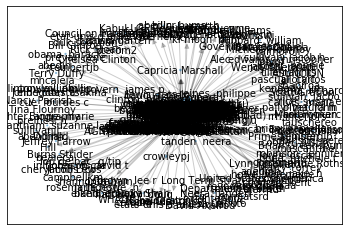

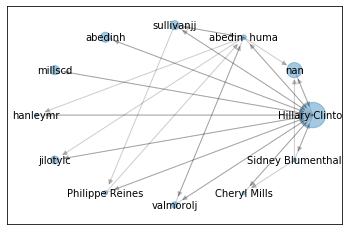

In [2]:
# -*- coding: utf-8 -*-
# 用PageRank挖掘希拉里邮件中的重要任务关系
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict

#数据加载
emails = pd.read_csv('Emails.csv')
#读取别名文件
file = pd.read_csv('Aliases.csv')
aliases = {}
for index,row in file.iterrows():
    aliases[row['Alias']] = row['PersonId']
# print(aliases)
#读取人名文件
file = pd.read_csv('Persons.csv')
person = {}
for index,row in file.iterrows():
    person[row['Id']] = row['Name']

#针对别名进行转化
def unify_name(name):
    #姓名统一小写
    name = str(name).lower()
    # 去掉, 和@后面的内容
    name = name.replace(',',' ').split('@')[0]
    # 别名转换
    if name in aliases.keys():
        return person[aliases[name]]
    return name
#画网格图
def show_graph(graph,type='spring_layout'):
    if type=='spring_layout':
        # 使用Spring Layout布局，类似中心放射状
        position = nx.spring_layout(graph)
    if type=='circular_layout':
        # 使用Circular Layout布局，在一个圆环上均匀分布
        position = nx.circular_layout(graph)   
    # 设置网络图中的节点大小，大小与pagerank值相关，因为pagerank值很小所以需要*2000
    nodesize = [x['pagerank']*2000 for v,x in graph.nodes(data=True)]
    # 设置网络中边长度
    edgesize = [np.sqrt(e[2]['weight']) for e in graph.edges(data=True)]
    # 绘制节点
    nx.draw_networkx_nodes(graph,position,node_size=nodesize,alpha=0.4)
    # 绘制边
    nx.draw_networkx_edges(graph,position,edge_size=edgesize,alpha=0.2)
    # 绘制节点的label
    nx.draw_networkx_labels(graph,position,font_size=10)
    # 输出希拉里邮件中的所有人物关系图
    plt.show()
    
# 将寄件人和收件人的姓名进行规范化
emails.MetadataTo = emails.MetadataTo.apply(unify_name)
emails.MetadataFrom = emails.MetadataFrom.apply(unify_name)

# 设置边的权重等于发邮件的次数
edges_weights_temp = defaultdict(list)
for row in zip(emails.MetadataFrom,emails.MetadataTo,emails.RawText):
    temp = (row[0],row[1])
    if temp not in edges_weights_temp:
        edges_weights_temp[temp] = 1
    else:
        edges_weights_temp[temp] = edges_weights_temp[temp]+1

# print(edges_weights_temp)
print('-'*100)
# 转化格式 (from, to), weight => from, to, weight
edges_weights = [(key[0],key[1],val) for key,val in edges_weights_temp.items()]

# 创建一个有向图
graph = nx.DiGraph()
# 设置有向图中的路径及权重(from, to, weight)
graph.add_weighted_edges_from(edges_weights)
# 计算每个节点（人）的PR值，并作为节点的pagerank属性
pagerank = nx.pagerank(graph)
# 获取每个节点的pagerank数值
pagerank_list = {node:rank for node,rank in pagerank.items()}
# 将pagerank数值作为节点的属性
nx.set_node_attributes(graph,name='pagerank',values=pagerank_list)
#画网格图
show_graph(graph)

# 将完整的图谱进行精简
# 设置PR值的阈值，筛选大于阈值的重要核心节点
pagerank_threshold = 0.005
# 复制一份计算好的网络图
small_graph = graph.copy()
# 剪掉PR值小于pagerank_threshold的节点
for n,p_rank in graph.nodes(data=True):
    if p_rank['pagerank']<pagerank_threshold:
        small_graph.remove_node(n)
    # 画网络图
show_graph(small_graph,'circular_layout')